In [1]:
import os
import math
import time
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss, Module
from torch.optim.lr_scheduler import ExponentialLR
from torchmetrics import AUROC, Accuracy, MeanSquaredError
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

from torch_frame import stype
from torch_frame.data import Dataset, DataLoader
from torch_frame.datasets import (
    ForestCoverType, KDDCensusIncome, DataFrameBenchmark,
    AdultCensusIncome, BankMarketing, Dota2
)
from torch_frame.gbdt import CatBoost, LightGBM, XGBoost
from torch_frame.nn import (
    EmbeddingEncoder, FTTransformer, LinearBucketEncoder,
    LinearEncoder, LinearPeriodicEncoder, ResNet, TabNet, TabTransformer
)
from torch_frame.nn.models import (
    MLP, ExcelFormer, Trompt
)
from torch_frame.typing import TaskType



# Use GPU for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
df = pd.read_csv("heart.csv")

# AutoEncoder

In [3]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded  # Bottleneck layer 값 반환

In [4]:
# Target은 AutoEncoder X
X_only = df.drop(columns=["HeartDisease"])

# continuous만 적용 예정
continuous_vars = X_only.select_dtypes(include=["int32", "int64", "float32", "float64"]).columns
categorical_vars = X_only.select_dtypes(include=["object"]).columns

# 모델 생성
input_dim = X_only[continuous_vars].shape[1]  # Feature 개수
hidden_dim = input_dim  # 축소 후 차원 (이 크기의 절반이 새로 만들어진 feature의 수)
autoencoder = Autoencoder(input_dim, hidden_dim)

# PyTorch 텐서 변환
X_tensor = torch.tensor(X_only[continuous_vars].values, dtype=torch.float32)

# Optimizer & Loss 설정
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.01)

In [5]:
# 학습
for epoch in range(50):
    optimizer.zero_grad()
    decoded, encoded = autoencoder(X_tensor)  # Bottleneck feature 추출
    loss = criterion(decoded, X_tensor)  # ✅ 디코더 출력과 원본 데이터 비교
    loss.backward()
    optimizer.step()


# Bottleneck feature 추출 (차원 축소된 데이터)
_, X_reduced = autoencoder(X_tensor)
X_reduced = X_reduced.detach().numpy()

# 👉 변환된 Feature를 DataFrame으로 변환
df_reduced = pd.DataFrame(X_reduced, index=df.index, columns=[f"reduced_{i}" for i in range(X_reduced.shape[1])])

# 🎯 원래 Target(y) 컬럼을 붙여서 최종 DataFrame 생성
df_AE = pd.concat([df[categorical_vars], df_reduced, df["HeartDisease"]], axis=1)

In [6]:
df_AE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             918 non-null    object 
 1   ChestPainType   918 non-null    object 
 2   RestingECG      918 non-null    object 
 3   ExerciseAngina  918 non-null    object 
 4   ST_Slope        918 non-null    object 
 5   reduced_0       918 non-null    float32
 6   reduced_1       918 non-null    float32
 7   reduced_2       918 non-null    float32
 8   HeartDisease    918 non-null    int64  
dtypes: float32(3), int64(1), object(5)
memory usage: 53.9+ KB


# ML

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
import catboost as cb
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [9]:
# Heart Disease를 종속 변수(y)로 설정
y_col = "HeartDisease"
y = df_AE[y_col]

# 독립 변수(X) 설정 (Patient_ID 제거)
X = df_AE.drop(columns=[y_col])

# 연속형 변수 (float, int)와 범주형 변수 분리
categorical_vars = X.select_dtypes(include=["object"]).columns.tolist()

df_encoded = pd.get_dummies(df_AE, columns=categorical_vars)
X = df_encoded.drop(columns=[y_col])

In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Model

### Logistic Regression

In [11]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
log_acc = accuracy_score(y_test, y_pred_log)
print(f'Logistic Regression Accuracy: {log_acc:.4f}')

Logistic Regression Accuracy: 0.8587


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest

In [12]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_acc:.4f}')

Random Forest Accuracy: 0.8406


### Decision Tree

In [13]:
dt_params = {'max_depth': [3, 5, 10, 15, None]}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy')
dt_grid.fit(X_train, y_train)
dt_best = dt_grid.best_estimator_

y_pred_dt = dt_best.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)

print("🔹 Decision Tree Results:")
print("Best Parameters:", dt_grid.best_params_)
print("Accuracy:", acc_dt)
print(classification_report(y_test, y_pred_dt))

🔹 Decision Tree Results:
Best Parameters: {'max_depth': 3}
Accuracy: 0.8188405797101449
              precision    recall  f1-score   support

           0       0.76      0.81      0.78       112
           1       0.87      0.82      0.84       164

    accuracy                           0.82       276
   macro avg       0.81      0.82      0.81       276
weighted avg       0.82      0.82      0.82       276



### XGBoost

In [14]:
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print("🔹 XGBoost Classifier Results:")
print("Accuracy:", acc_xgb)
print(classification_report(y_test, y_pred_xgb))

/opt/conda/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [07:55:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔹 XGBoost Classifier Results:
Accuracy: 0.8478260869565217
              precision    recall  f1-score   support

           0       0.78      0.88      0.82       112
           1       0.91      0.83      0.87       164

    accuracy                           0.85       276
   macro avg       0.84      0.85      0.84       276
weighted avg       0.85      0.85      0.85       276



### LightGBM

In [15]:
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.05, 
                                 n_estimators=200, force_col_wise=True, random_state=42)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)

acc_lgb = accuracy_score(y_test, y_pred_lgb)

print("🔹 LightGBM Model Performance 🔹")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))

[LightGBM] [Info] Number of positive: 344, number of negative: 298
[LightGBM] [Info] Total Bins 458
[LightGBM] [Info] Number of data points in the train set: 642, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535826 -> initscore=0.143548
[LightGBM] [Info] Start training from score 0.143548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

### CatBoost

In [16]:
cat_model = cb.CatBoostClassifier(iterations=200, depth=6, learning_rate=0.05, loss_function='Logloss', verbose=0, random_seed=42)
cat_model.fit(X_train, y_train)

y_pred_cat = cat_model.predict(X_test)

acc_cat = accuracy_score(y_test, y_pred_cat)

print("🔹 CatBoost Model Performance 🔹")
print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print(classification_report(y_test, y_pred_cat))

🔹 CatBoost Model Performance 🔹
Accuracy: 0.8804347826086957
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       112
           1       0.92      0.87      0.90       164

    accuracy                           0.88       276
   macro avg       0.87      0.88      0.88       276
weighted avg       0.88      0.88      0.88       276



# DL

In [22]:
# 분류 task
is_classification = True

In [23]:
from torch_frame import numerical, categorical, text_embedded, embedding
from torch_frame.config.text_embedder import TextEmbedderConfig

## 칼럼 별 Dtype 지정 
col_to_stype={"Sex" : categorical,
              "ChestPainType" : categorical,
              "RestingECG" : categorical,
              "ExerciseAngina" : categorical,
              "ST_Slope" : categorical,
              "reduced_0" : numerical,
              "reduced_1" : numerical,
              "reduced_2" : numerical,
              "HeartDisease" :numerical}

dataset = Dataset(df=df_AE, 
                  col_to_stype=col_to_stype, 
                  target_col='HeartDisease')

dataset.materialize()

## split
train_dataset, val_dataset, test_dataset = dataset[:0.6], dataset[0.6:0.7], dataset[0.7:]

### ResNet

In [24]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='adult')
parser.add_argument('--numerical_encoder_type', type=str, default='linear',
                    choices=['linear', 'linearbucket', 'linearperiodic'])
parser.add_argument('--model_type', type=str, default='fttransformer',
                    choices=['fttransformer', 'resnet'])
parser.add_argument('--channels', type=int, default=256)
parser.add_argument('--num_layers', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

_StoreTrueAction(option_strings=['--compile'], dest='compile', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [25]:
# Jupyter에서 실행될 때는 sys.argv를 조정
args = parser.parse_args([
    #'--dataset', 'adult',
    '--numerical_encoder_type', 'linear',
    '--model_type', 'resnet',       # fttransformer : FT-T / resnet : ResNet
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [26]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

if args.numerical_encoder_type == 'linear':
    numerical_encoder = LinearEncoder()
elif args.numerical_encoder_type == 'linearbucket':
    numerical_encoder = LinearBucketEncoder()
elif args.numerical_encoder_type == 'linearperiodic':
    numerical_encoder = LinearPeriodicEncoder()
else:
    raise ValueError(
        f'Unsupported encoder type: {args.numerical_encoder_type}')

stype_encoder_dict = {
    stype.categorical: EmbeddingEncoder(),
    stype.numerical: numerical_encoder,
}

if is_classification:
    #output_channels = dataset.num_classes    ->   contains StatType.COUNT을 포함하지 않아서 오류(?)
    output_channels = 2 # 그냥 수동으로 설정.,,,,   => 분류 칼럼 unique 개수로 설정 
else:
    output_channels = 1

In [27]:
if args.model_type == 'fttransformer':
    model = FTTransformer(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,    # TensorFrame이 col_stats를 안받아서 transor frame으로 바꾸기 전으로 받아와야 함 
        col_names_dict=train_tensor_frame.col_names_dict,
        stype_encoder_dict=stype_encoder_dict,
    ).to(device)

elif args.model_type == 'resnet':
    model = ResNet(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,
        col_names_dict=train_tensor_frame.col_names_dict,
    ).to(device)
else:
    raise ValueError(f'Unsupported model type: {args.model_type}')

model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)

In [28]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse


In [29]:
# 훈련 및 테스트

if is_classification:
    metric = 'Acc'
    best_val_metric = 0
    best_test_metric = 0
else:
    metric = 'RMSE'
    best_val_metric = float('inf')
    best_test_metric = float('inf')

for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_metric = test(train_loader)
    val_metric = test(val_loader)
    test_metric = test(test_loader)

    if is_classification and val_metric > best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric
    elif not is_classification and val_metric < best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric

    print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
          f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')

print(f'Best Val {metric}: {best_val_metric:.4f}, '
      f'Best Test {metric}: {best_test_metric:.4f}')


Epoch: 1: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


Train Loss: 0.5980, Train Acc: 0.8566, Val Acc: 0.7826, Test Acc: 0.7709


Epoch: 2: 100%|██████████| 3/3 [00:00<00:00, 118.33it/s]


Train Loss: 0.3780, Train Acc: 0.8875, Val Acc: 0.8370, Test Acc: 0.7964


Epoch: 3: 100%|██████████| 3/3 [00:00<00:00, 91.68it/s]


Train Loss: 0.3180, Train Acc: 0.8875, Val Acc: 0.8370, Test Acc: 0.7964


Epoch: 4: 100%|██████████| 3/3 [00:00<00:00, 89.83it/s]


Train Loss: 0.3079, Train Acc: 0.8893, Val Acc: 0.8478, Test Acc: 0.7782


Epoch: 5: 100%|██████████| 3/3 [00:00<00:00, 83.67it/s]


Train Loss: 0.2917, Train Acc: 0.8929, Val Acc: 0.8370, Test Acc: 0.7491


Epoch: 6: 100%|██████████| 3/3 [00:00<00:00, 90.18it/s]


Train Loss: 0.2896, Train Acc: 0.8929, Val Acc: 0.8370, Test Acc: 0.7491


Epoch: 7: 100%|██████████| 3/3 [00:00<00:00, 90.61it/s]


Train Loss: 0.3006, Train Acc: 0.8929, Val Acc: 0.8370, Test Acc: 0.7491


Epoch: 8: 100%|██████████| 3/3 [00:00<00:00, 88.62it/s]


Train Loss: 0.2949, Train Acc: 0.8947, Val Acc: 0.8370, Test Acc: 0.7491


Epoch: 9: 100%|██████████| 3/3 [00:00<00:00, 86.75it/s]


Train Loss: 0.2879, Train Acc: 0.8947, Val Acc: 0.8370, Test Acc: 0.7455


Epoch: 10: 100%|██████████| 3/3 [00:00<00:00, 93.35it/s]


Train Loss: 0.2857, Train Acc: 0.8911, Val Acc: 0.8261, Test Acc: 0.7491


Epoch: 11: 100%|██████████| 3/3 [00:00<00:00, 91.49it/s]


Train Loss: 0.2882, Train Acc: 0.8929, Val Acc: 0.8370, Test Acc: 0.7455


Epoch: 12: 100%|██████████| 3/3 [00:00<00:00, 91.47it/s]


Train Loss: 0.2909, Train Acc: 0.8947, Val Acc: 0.8261, Test Acc: 0.7455


Epoch: 13: 100%|██████████| 3/3 [00:00<00:00, 88.33it/s]


Train Loss: 0.2807, Train Acc: 0.8947, Val Acc: 0.8370, Test Acc: 0.7455


Epoch: 14: 100%|██████████| 3/3 [00:00<00:00, 89.89it/s]


Train Loss: 0.2853, Train Acc: 0.8947, Val Acc: 0.8478, Test Acc: 0.7382


Epoch: 15: 100%|██████████| 3/3 [00:00<00:00, 97.18it/s]


Train Loss: 0.2796, Train Acc: 0.8947, Val Acc: 0.8587, Test Acc: 0.7382
Best Val Acc: 0.8587, Best Test Acc: 0.7382


In [30]:
resnet_score = best_test_metric
resnet_score

0.7381818181818182

### FT-T

In [31]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='adult')
parser.add_argument('--numerical_encoder_type', type=str, default='linear',
                    choices=['linear', 'linearbucket', 'linearperiodic'])
parser.add_argument('--model_type', type=str, default='fttransformer',
                    choices=['fttransformer', 'resnet'])
parser.add_argument('--channels', type=int, default=256)
parser.add_argument('--num_layers', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

_StoreTrueAction(option_strings=['--compile'], dest='compile', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [32]:
# Jupyter에서 실행될 때는 sys.argv를 조정
args = parser.parse_args([
    #'--dataset', 'adult',
    '--numerical_encoder_type', 'linear',
    '--model_type', 'fttransformer',       # fttransformer : FT-T / resnet : ResNet
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [33]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

if args.numerical_encoder_type == 'linear':
    numerical_encoder = LinearEncoder()
elif args.numerical_encoder_type == 'linearbucket':
    numerical_encoder = LinearBucketEncoder()
elif args.numerical_encoder_type == 'linearperiodic':
    numerical_encoder = LinearPeriodicEncoder()
else:
    raise ValueError(
        f'Unsupported encoder type: {args.numerical_encoder_type}')

stype_encoder_dict = {
    stype.categorical: EmbeddingEncoder(),
    stype.numerical: numerical_encoder,
}

if is_classification:
    #output_channels = dataset.num_classes    ->   contains StatType.COUNT을 포함하지 않아서 오류(?)
    output_channels = 2 # 그냥 수동으로 설정.,,,,   => 분류 칼럼 unique 개수로 설정 
else:
    output_channels = 1

In [34]:
if args.model_type == 'fttransformer':
    model = FTTransformer(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,    # TensorFrame이 col_stats를 안받아서 transor frame으로 바꾸기 전으로 받아와야 함 
        col_names_dict=train_tensor_frame.col_names_dict,
        stype_encoder_dict=stype_encoder_dict,
    ).to(device)

elif args.model_type == 'resnet':
    model = ResNet(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,
        col_names_dict=train_tensor_frame.col_names_dict,
    ).to(device)
else:
    raise ValueError(f'Unsupported model type: {args.model_type}')

model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)

In [35]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse


In [36]:
# 훈련 및 테스트

if is_classification:
    metric = 'Acc'
    best_val_metric = 0
    best_test_metric = 0
else:
    metric = 'RMSE'
    best_val_metric = float('inf')
    best_test_metric = float('inf')

for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_metric = test(train_loader)
    val_metric = test(val_loader)
    test_metric = test(test_loader)

    if is_classification and val_metric > best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric
    elif not is_classification and val_metric < best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric

    print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
          f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')

print(f'Best Val {metric}: {best_val_metric:.4f}, '
      f'Best Test {metric}: {best_test_metric:.4f}')


Epoch: 1: 100%|██████████| 3/3 [00:00<00:00, 40.41it/s]


Train Loss: 0.7745, Train Acc: 0.7695, Val Acc: 0.6522, Test Acc: 0.5855


Epoch: 2: 100%|██████████| 3/3 [00:00<00:00, 42.50it/s]


Train Loss: 0.5555, Train Acc: 0.8403, Val Acc: 0.6739, Test Acc: 0.7018


Epoch: 3: 100%|██████████| 3/3 [00:00<00:00, 42.47it/s]


Train Loss: 0.4803, Train Acc: 0.8875, Val Acc: 0.8043, Test Acc: 0.7418


Epoch: 4: 100%|██████████| 3/3 [00:00<00:00, 47.16it/s]


Train Loss: 0.3914, Train Acc: 0.8875, Val Acc: 0.8370, Test Acc: 0.7782


Epoch: 5: 100%|██████████| 3/3 [00:00<00:00, 43.18it/s]


Train Loss: 0.3708, Train Acc: 0.8875, Val Acc: 0.8370, Test Acc: 0.7709


Epoch: 6: 100%|██████████| 3/3 [00:00<00:00, 43.18it/s]


Train Loss: 0.3184, Train Acc: 0.8911, Val Acc: 0.8370, Test Acc: 0.7564


Epoch: 7: 100%|██████████| 3/3 [00:00<00:00, 46.14it/s]


Train Loss: 0.3165, Train Acc: 0.8911, Val Acc: 0.8370, Test Acc: 0.7564


Epoch: 8: 100%|██████████| 3/3 [00:00<00:00, 43.55it/s]


Train Loss: 0.3053, Train Acc: 0.8929, Val Acc: 0.8370, Test Acc: 0.7491


Epoch: 9: 100%|██████████| 3/3 [00:00<00:00, 37.74it/s]


Train Loss: 0.3004, Train Acc: 0.8929, Val Acc: 0.8370, Test Acc: 0.7491


Epoch: 10: 100%|██████████| 3/3 [00:00<00:00, 25.15it/s]


Train Loss: 0.3030, Train Acc: 0.8911, Val Acc: 0.8370, Test Acc: 0.7564


Epoch: 11: 100%|██████████| 3/3 [00:00<00:00, 37.23it/s]


Train Loss: 0.3073, Train Acc: 0.8911, Val Acc: 0.8370, Test Acc: 0.7564


Epoch: 12: 100%|██████████| 3/3 [00:00<00:00, 35.22it/s]


Train Loss: 0.3040, Train Acc: 0.8929, Val Acc: 0.8370, Test Acc: 0.7491


Epoch: 13: 100%|██████████| 3/3 [00:00<00:00, 46.67it/s]


Train Loss: 0.3077, Train Acc: 0.8929, Val Acc: 0.8370, Test Acc: 0.7491


Epoch: 14: 100%|██████████| 3/3 [00:00<00:00, 63.43it/s]


Train Loss: 0.2918, Train Acc: 0.8929, Val Acc: 0.8370, Test Acc: 0.7491


Epoch: 15: 100%|██████████| 3/3 [00:00<00:00, 48.62it/s]

Train Loss: 0.2923, Train Acc: 0.8838, Val Acc: 0.8152, Test Acc: 0.7345
Best Val Acc: 0.8370, Best Test Acc: 0.7782


In [37]:
ftt_score = best_test_metric
ftt_score

0.7781818181818182

### TabNet

In [38]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default="ForestCoverType",
                    choices=["ForestCoverType", "KDDCensusIncome"])
parser.add_argument('--channels', type=int, default=128)
parser.add_argument('--gamma', type=int, default=1.2)
parser.add_argument('--num_layers', type=int, default=6)
parser.add_argument('--batch_size', type=int, default=4096)
parser.add_argument('--lr', type=float, default=0.005)
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')


args = parser.parse_args([
    "--channels", "256",
    "--num_layers", "4",
    "--batch_size", "256",
    "--lr", "0.0001",
    "--epochs", "15"
])

torch.manual_seed(args.seed)

In [39]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

In [40]:
# Set up model and optimizer
model = TabNet(
    out_channels = 2,
    num_layers=args.num_layers,
    split_attn_channels=args.channels,
    split_feat_channels=args.channels,
    gamma=args.gamma,
    col_stats=dataset.col_stats,
    col_names_dict=train_tensor_frame.col_names_dict,
).to(device)
model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
lr_scheduler = ExponentialLR(optimizer, gamma=0.95)

In [41]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        loss = F.cross_entropy(pred, tf.y.long())
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        pred_class = pred.argmax(dim=-1)
        accum += float((tf.y == pred_class).sum())
        total_count += len(tf.y)

    return accum / total_count

In [42]:
best_val_acc = 0
best_test_acc = 0
for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    test_acc = test(test_loader)
    if best_val_acc < val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
    lr_scheduler.step()

print(f'Best Val Acc: {best_val_acc:.4f}, Best Test Acc: {best_test_acc:.4f}')

Epoch: 1: 100%|██████████| 3/3 [00:00<00:00, 48.13it/s]


Train Loss: 0.6941, Train Acc: 0.4465, Val Acc: 0.4022, Test Acc: 0.5564


Epoch: 2: 100%|██████████| 3/3 [00:00<00:00, 73.32it/s]


Train Loss: 0.6838, Train Acc: 0.6679, Val Acc: 0.6413, Test Acc: 0.6327


Epoch: 3: 100%|██████████| 3/3 [00:00<00:00, 55.97it/s]


Train Loss: 0.6734, Train Acc: 0.7713, Val Acc: 0.7283, Test Acc: 0.7309


Epoch: 4: 100%|██████████| 3/3 [00:00<00:00, 76.94it/s]


Train Loss: 0.6617, Train Acc: 0.8058, Val Acc: 0.7283, Test Acc: 0.7273


Epoch: 5: 100%|██████████| 3/3 [00:00<00:00, 70.63it/s]


Train Loss: 0.6499, Train Acc: 0.8330, Val Acc: 0.7283, Test Acc: 0.7273


Epoch: 6: 100%|██████████| 3/3 [00:00<00:00, 51.05it/s]


Train Loss: 0.6373, Train Acc: 0.8330, Val Acc: 0.7283, Test Acc: 0.7345


Epoch: 7: 100%|██████████| 3/3 [00:00<00:00, 68.19it/s]


Train Loss: 0.6245, Train Acc: 0.8348, Val Acc: 0.7283, Test Acc: 0.7273


Epoch: 8: 100%|██████████| 3/3 [00:00<00:00, 75.07it/s]


Train Loss: 0.6109, Train Acc: 0.8294, Val Acc: 0.7391, Test Acc: 0.7309


Epoch: 9: 100%|██████████| 3/3 [00:00<00:00, 53.52it/s]


Train Loss: 0.5987, Train Acc: 0.8294, Val Acc: 0.7391, Test Acc: 0.7345


Epoch: 10: 100%|██████████| 3/3 [00:00<00:00, 67.38it/s]


Train Loss: 0.5872, Train Acc: 0.8312, Val Acc: 0.7065, Test Acc: 0.7273


Epoch: 11: 100%|██████████| 3/3 [00:00<00:00, 73.77it/s]


Train Loss: 0.5742, Train Acc: 0.8312, Val Acc: 0.7065, Test Acc: 0.7345


Epoch: 12: 100%|██████████| 3/3 [00:00<00:00, 50.45it/s]


Train Loss: 0.5620, Train Acc: 0.8367, Val Acc: 0.7065, Test Acc: 0.7382


Epoch: 13: 100%|██████████| 3/3 [00:00<00:00, 31.69it/s]


Train Loss: 0.5486, Train Acc: 0.8367, Val Acc: 0.7065, Test Acc: 0.7418


Epoch: 14: 100%|██████████| 3/3 [00:00<00:00, 51.00it/s]


Train Loss: 0.5372, Train Acc: 0.8421, Val Acc: 0.7065, Test Acc: 0.7491


Epoch: 15: 100%|██████████| 3/3 [00:00<00:00, 40.30it/s]


Train Loss: 0.5265, Train Acc: 0.8439, Val Acc: 0.7174, Test Acc: 0.7527
Best Val Acc: 0.7391, Best Test Acc: 0.7309


In [43]:
tabnet_score = best_test_acc
tabnet_score

0.730909090909091

### Tab_Transformer

In [44]:
# Jupyter에서 실행될 때는 sys.argv를 조정
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='dota2',
                    choices=["adult", "dota2", "bank-marketing"])
parser.add_argument('--channels', type=int, default=32)
parser.add_argument('--num_heads', type=int, default=8)
parser.add_argument('--num_layers', type=int, default=6)
parser.add_argument('--encoder_pad_size', type=int, default=2)
parser.add_argument('--attention_dropout', type=float, default=0.3)
parser.add_argument('--ffn_dropout', type=float, default=0.3)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

args = parser.parse_args([
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [45]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

In [46]:
# Set up model and optimizer
model = TabTransformer(
    channels=args.channels,
    out_channels= 2,        # stype 문제로 수동으로 설정 
    num_layers=args.num_layers,
    num_heads=args.num_heads,
    encoder_pad_size=args.encoder_pad_size,
    attn_dropout=args.attention_dropout,
    ffn_dropout=args.ffn_dropout,
    col_stats=dataset.col_stats,
    col_names_dict=train_tensor_frame.col_names_dict,
).to(device)
model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
lr_scheduler = ExponentialLR(optimizer, gamma=0.95)

In [47]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model.forward(tf)
        loss = F.cross_entropy(pred, tf.y.long())   # expected scalar type Long but found Float 때문에 tf.y => tf.y.long()
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse

In [48]:
metric = 'ACC'
best_val_metric = 0
best_test_metric = 0
for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_metric = test(train_loader)
    val_metric = test(val_loader)
    test_metric = test(test_loader)

    if val_metric > best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric

    print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
          f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')
    lr_scheduler.step()

print(f'Best Val {metric}: {best_val_metric:.4f}, '
      f'Best Test {metric}: {best_test_metric:.4f}')

Epoch: 1: 100%|██████████| 3/3 [00:00<00:00, 32.65it/s]


Train Loss: 0.8251, Train ACC: 0.8802, Val ACC: 0.8370, Test ACC: 0.7636


Epoch: 2: 100%|██████████| 3/3 [00:00<00:00, 51.42it/s]


Train Loss: 0.4542, Train ACC: 0.8766, Val ACC: 0.8478, Test ACC: 0.7309


Epoch: 3: 100%|██████████| 3/3 [00:00<00:00, 44.33it/s]


Train Loss: 0.5309, Train ACC: 0.8802, Val ACC: 0.8478, Test ACC: 0.7491


Epoch: 4: 100%|██████████| 3/3 [00:00<00:00, 48.31it/s]


Train Loss: 0.4349, Train ACC: 0.8784, Val ACC: 0.8261, Test ACC: 0.7673


Epoch: 5: 100%|██████████| 3/3 [00:00<00:00, 51.97it/s]


Train Loss: 0.4802, Train ACC: 0.8766, Val ACC: 0.8370, Test ACC: 0.7782


Epoch: 6: 100%|██████████| 3/3 [00:00<00:00, 35.00it/s]


Train Loss: 0.4698, Train ACC: 0.8857, Val ACC: 0.8370, Test ACC: 0.7636


Epoch: 7: 100%|██████████| 3/3 [00:00<00:00, 46.76it/s]


Train Loss: 0.4522, Train ACC: 0.8802, Val ACC: 0.8478, Test ACC: 0.7600


Epoch: 8: 100%|██████████| 3/3 [00:00<00:00, 50.73it/s]


Train Loss: 0.4274, Train ACC: 0.8802, Val ACC: 0.8261, Test ACC: 0.7418


Epoch: 9: 100%|██████████| 3/3 [00:00<00:00, 37.72it/s]


Train Loss: 0.4535, Train ACC: 0.8802, Val ACC: 0.8478, Test ACC: 0.7382


Epoch: 10: 100%|██████████| 3/3 [00:00<00:00, 33.89it/s]


Train Loss: 0.4348, Train ACC: 0.8784, Val ACC: 0.8478, Test ACC: 0.7600


Epoch: 11: 100%|██████████| 3/3 [00:00<00:00, 38.22it/s]


Train Loss: 0.4811, Train ACC: 0.8857, Val ACC: 0.8261, Test ACC: 0.7855


Epoch: 12: 100%|██████████| 3/3 [00:00<00:00, 40.00it/s]


Train Loss: 0.3926, Train ACC: 0.8857, Val ACC: 0.8370, Test ACC: 0.7418


Epoch: 13: 100%|██████████| 3/3 [00:00<00:00, 27.64it/s]


Train Loss: 0.3929, Train ACC: 0.8911, Val ACC: 0.8587, Test ACC: 0.7564


Epoch: 14: 100%|██████████| 3/3 [00:00<00:00, 34.33it/s]


Train Loss: 0.3941, Train ACC: 0.8875, Val ACC: 0.8478, Test ACC: 0.7527


Epoch: 15: 100%|██████████| 3/3 [00:00<00:00, 34.23it/s]

Train Loss: 0.4046, Train ACC: 0.8966, Val ACC: 0.8478, Test ACC: 0.7782
Best Val ACC: 0.8587, Best Test ACC: 0.7564


In [49]:
tab_transformer_score = best_test_metric
tab_transformer_score

0.7563636363636363

# 시각화

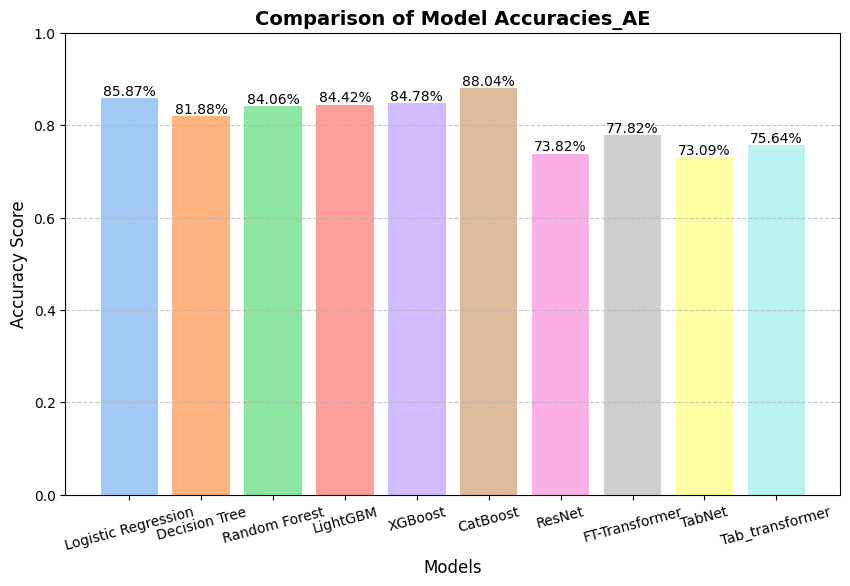

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'LightGBM', 'XGBoost', 'CatBoost', 'ResNet', 'FT-Transformer', 'TabNet', 'Tab_transformer']
accuracies = [log_acc, acc_dt, rf_acc, acc_lgb, acc_xgb, acc_cat, resnet_score, ftt_score, tabnet_score, tab_transformer_score]

colors = sns.color_palette("pastel", len(models))

plt.figure(figsize=(10, 6))

# 바 차트 그리기
bars = plt.bar(models, accuracies, color=colors,  linewidth=1.2)

plt.ylim(0, 1)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{acc:.2%}",
             ha='center', va='bottom', fontsize=10)


plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy Score", fontsize=12)
plt.title("Comparison of Model Accuracies_AE", fontsize=14, fontweight='bold')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()